# Dataset Acquisition and Exploration

This notebook explores the Musical Instrument Classification dataset and demonstrates how to use the new project structure.

In [21]:
# Setup: Add project root to path to enable imports from src
import os
import sys
from pathlib import Path

# Add project root to path to ensure imports work correctly
project_root = str(Path().resolve().parent)
sys.path.append(project_root)

print(f"Project root added to path: {project_root}")

Project root added to path: C:\Users\Daniel\Desktop\Univeristy\ULB\Master\MA1\MA1-Q2\X-PROJ-H419\proj-h419-MIC


### 1. Initial Dataset Inspection (Code-based Verification)

In [22]:
import os

base_dir = "../data/raw/30_Musical_Instruments"

for folder in ['train', 'valid', 'test']:
    folder_path = os.path.join(base_dir, folder)
    total_images = sum([len(files) for _, _, files in os.walk(folder_path)])
    print(f"{folder.capitalize()} set: {total_images} images")

Train set: 4793 images
Valid set: 150 images
Test set: 150 images


 ### 2. Load and Understand the CSV Metadata

`class_dict.csv`: Helps map numeric labels to instrument names.

In [23]:
import pandas as pd

class_dict = pd.read_csv("../data/raw/30_Musical_Instruments/class_dict.csv")
print(class_dict)  # This will display all rows in the DataFrame

# Explanation :
# The class_dict.csv file contains the mapping of class names to their respective class labels.
# The class labels are used to identify the class of the instrument in the dataset.
# The class names are the names of the musical instruments.

    class_index       class  height  width  scale by
0             0  Didgeridoo     224    224         1
1             1  Tambourine     224    224         1
2             2   Xylophone     224    224         1
3             3    acordian     224    224         1
4             4     alphorn     224    224         1
5             5    bagpipes     224    224         1
6             6       banjo     224    224         1
7             7  bongo drum     224    224         1
8             8      casaba     224    224         1
9             9   castanets     224    224         1
10           10    clarinet     224    224         1
11           11  clavichord     224    224         1
12           12  concertina     224    224         1
13           13       drums     224    224         1
14           14    dulcimer     224    224         1
15           15       flute     224    224         1
16           16       guiro     224    224         1
17           17      guitar     224    224    

### 3. Visual Inspection & Exploration

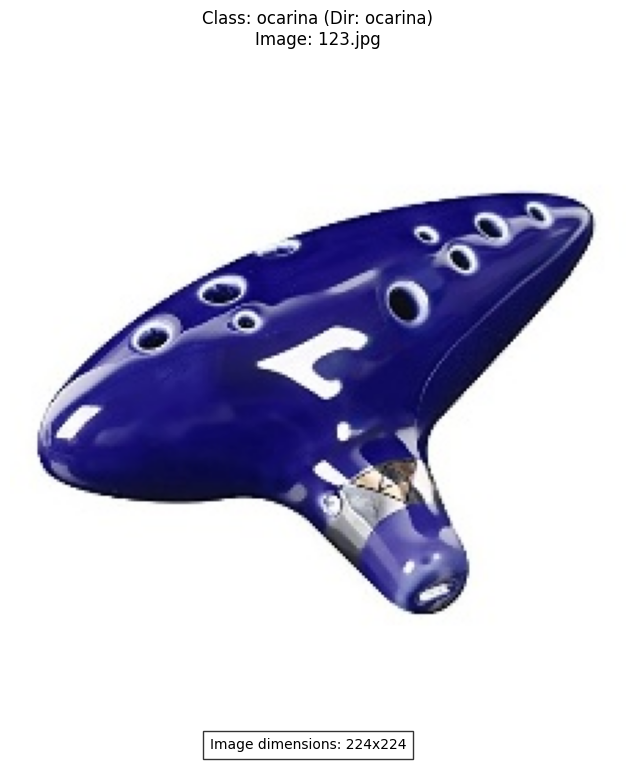

In [24]:
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Select a random instrument class from the training set
train_path = "../data/raw/30_Musical_Instruments/train"
random_class = random.choice(os.listdir(train_path))

# Create a temporary dataset to get the class_to_idx mapping
temp_transform = transforms.Compose([transforms.ToTensor()])
train_dataset_temp = ImageFolder(train_path, transform=temp_transform)

# Find the corresponding human-readable instrument name from class_dict
class_index = int(train_dataset_temp.class_to_idx[random_class])
instrument_name = class_dict.loc[class_dict['class_index'] == class_index, 'class'].values[0]

# Get a random image from the selected class
class_folder = os.path.join(train_path, random_class)
image_file = random.choice(os.listdir(class_folder))
img_path = os.path.join(class_folder, image_file)

# Open and display the image
img = Image.open(img_path)

# Create a more informative visualization
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Class: {instrument_name} (Dir: {random_class})\nImage: {image_file}", fontsize=12)
plt.axis('off')

# Add information about image dimensions
plt.figtext(0.5, 0.01, f"Image dimensions: {img.width}x{img.height}", 
            ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.show()

### 4. Define the Image Preprocessing Pipeline

We'll use the preprocessing utilities from our new project structure.

* Choose a consistent size (recommended: 224x224) for compatibility with common CNN architectures.
* Normalize images (standard normalization for CNNs)
* Our project's `src.data.preprocessing` module handles this for us

In [25]:
# Import our preprocessing utilities
from src.data.preprocessing import get_preprocessing_transforms

# Get standard transforms (includes 224x224 resizing and normalization)
transforms = get_preprocessing_transforms(img_size=224)
print("Available transform types:", list(transforms.keys()))

# Use the validation/test transform for exploration (no augmentation)
transform = transforms['val']

Available transform types: ['train', 'val', 'test']


### 5. Prepare Data Loading for Training

We'll use the dataloader utilities from our new project structure to simplify data loading.

In [26]:
# Import our data loading utilities
from src.data.dataloader import load_datasets

# Load all datasets using our utility function
data = load_datasets(
    data_dir=base_dir, 
    transforms=transforms,
    batch_size=32,
    num_workers=0,  # Set to higher value if you have more CPU cores
    pin_memory=False  # Set to True if using GPU
)

# Access the components
train_loader = data['dataloaders']['train']
valid_loader = data['dataloaders']['val']
test_loader = data['dataloaders']['test']

# Access class information
idx_to_class = data['class_mappings']['idx_to_class']
class_to_idx = data['class_mappings']['class_to_idx']
num_classes = data['num_classes']

# Verify loader works correctly
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Number of classes: {num_classes}")
print(f"First few class names: {list(idx_to_class.values())[:5]}")

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Number of classes: 30
First few class names: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn']


### 6. Using Data Augmentation

Our project structure includes advanced augmentation options that we can explore.

In [27]:
# Import augmentation utilities
from src.data.augmentation import AdvancedAugmentation

# Get augmented transforms with different strength levels
light_transforms = AdvancedAugmentation.get_advanced_transforms(
    img_size=224, 
    augmentation_strength='light'
)

medium_transforms = AdvancedAugmentation.get_advanced_transforms(
    img_size=224, 
    augmentation_strength='medium'
)

strong_transforms = AdvancedAugmentation.get_advanced_transforms(
    img_size=224, 
    augmentation_strength='strong'
)

print("Different augmentation strengths are available for training:")
print("- light: minimal augmentation")
print("- medium: moderate augmentation (default)")
print("- strong: aggressive augmentation")

Different augmentation strengths are available for training:
- light: minimal augmentation
- medium: moderate augmentation (default)
- strong: aggressive augmentation


### 7. Exploring GPU Availability

For training acceleration, we can use the GPU detection utility from our project structure.

In [28]:
# Import GPU detection utility
from scripts.colab_integration import check_gpu

# Check GPU availability (will work on both Colab and local environment)
device = check_gpu()

Using device: cpu
No GPU detected, using CPU. Training will be slower.
